In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms

In [2]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

mps


In [3]:
dataset_path = 'datasets/B-Disease_Grading'
data_path = '1-Original_Images'
label_path = '2-Groundtruths'

train_data_path = os.path.join(dataset_path, data_path, 'a-Train_Set')
test_data_path = os.path.join(dataset_path, data_path, 'b-Test_Set')
train_labels = os.path.join(dataset_path, label_path, 'a-Train_Labels.csv')
test_labels = os.path.join(dataset_path, label_path, 'b-Test_Labels.csv')

In [4]:
class IDRiDDataset(Dataset):
    def __init__(self, img_dir, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx]['Image name'] + '.jpg'
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path)#.convert('RGB')

        retinopathy = int(self.data.iloc[idx]['Retinopathy grade'])
        edema = int(self.data.iloc[idx]['Risk of macular edema '])

        if self.transform:
            image = self.transform(image)

        return image, {'retinopathy': retinopathy, 'edema': edema}

In [5]:
def compute_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=0)

    mean = 0.0
    std = 0.0
    nb_samples = 0

    for images, _ in tqdm(loader):
        batch_samples = images.size(0)  # batch size (32)
        images = images.view(batch_samples, images.size(1), -1)  # [B, C, H*W]
        
        mean += images.mean(2).sum(0)  # sum of channel means
        std += images.std(2).sum(0)    # sum of channel stds
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples

    return mean.numpy(), std.numpy()

transform_mean_std = transforms.Compose([
    transforms.Resize(512),
    transforms.CenterCrop(448),
    transforms.ToTensor()
])

dataset_mean_std = IDRiDDataset(
    img_dir=train_data_path,
    csv_file=train_labels,
    transform=transform_mean_std
)

mean, std = compute_mean_std(dataset_mean_std)
print(f"Mean: {mean}\nStd: {std}")

100%|██████████| 13/13 [00:12<00:00,  1.05it/s]

Mean: [0.64398366 0.31709325 0.10248035]
Std: [0.11275874 0.08133845 0.03794106]


In [ ]:
transform = transforms.Compose([
    transforms.Resize(512),
    transforms.CenterCrop(448),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

train_val_dataset = IDRiDDataset(
    img_dir=train_data_path,
    csv_file=train_labels,
    transform=transform
)

train_dataset, val_dataset = random_split(train_val_dataset, [0.8, 0.2])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)   # [B, 3, 448, 448]
        self.pool1 = nn.MaxPool2d(2, 2)                           # [B, 32, 224, 224]

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # [B, 32, 224, 224]
        self.pool2 = nn.MaxPool2d(2, 2)                           # [B, 64, 112, 112]

        self.fc1 = nn.Linear(64 * 112 * 112, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))

        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
num_classes = len(pd.read_csv(train_labels)['Retinopathy grade'].unique())
cnn_model = SimpleCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

In [9]:
def train(model, train_loader, val_loader, optimizer, criterion, device, epochs=10):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(epochs):
        # === Training Phase ===
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for images, labels in train_loader:
            images = images.to(device)
            targets = labels['retinopathy'].to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            train_total += targets.size(0)
            train_correct += (predicted == targets).sum().item()

        avg_train_loss = train_loss / train_total
        train_acc = 100 * train_correct / train_total

        # === Validation Phase ===
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                targets = labels['retinopathy'].to(device)

                outputs = model(images)
                loss = criterion(outputs, targets)

                val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()

        avg_val_loss = val_loss / val_total
        val_acc = 100 * val_correct / val_total

        train_losses.append(avg_train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)

        # Print metrics after each epoch
        epochs_length = len(str(epochs))
        print(f"Epoch {epoch+1:0{epochs_length}}/{epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    
    return train_losses, train_accuracies, val_losses, val_accuracies

In [10]:
train_losses, train_accuracies, val_losses, val_accuracies = train(cnn_model, train_loader, val_loader,
                                                                   optimizer, criterion, device, epochs=25)

Epoch 01/25 | Train Loss: 51.8993 | Train Acc: 35.65% | Val Loss: 3.4841 | Val Acc: 50.00%
Epoch 02/25 | Train Loss: 1.7333 | Train Acc: 30.51% | Val Loss: 1.5892 | Val Acc: 32.93%
Epoch 03/25 | Train Loss: 1.5838 | Train Acc: 33.53% | Val Loss: 1.5785 | Val Acc: 30.49%
Epoch 04/25 | Train Loss: 1.5728 | Train Acc: 32.93% | Val Loss: 1.5601 | Val Acc: 30.49%
Epoch 05/25 | Train Loss: 1.5490 | Train Acc: 33.23% | Val Loss: 1.5281 | Val Acc: 32.93%
Epoch 06/25 | Train Loss: 1.5050 | Train Acc: 34.14% | Val Loss: 1.4687 | Val Acc: 35.37%
Epoch 07/25 | Train Loss: 1.4579 | Train Acc: 35.35% | Val Loss: 1.4087 | Val Acc: 37.80%
Epoch 08/25 | Train Loss: 1.3756 | Train Acc: 47.73% | Val Loss: 1.3135 | Val Acc: 50.00%
Epoch 09/25 | Train Loss: 1.3081 | Train Acc: 49.24% | Val Loss: 1.3312 | Val Acc: 52.44%
Epoch 10/25 | Train Loss: 1.2145 | Train Acc: 52.27% | Val Loss: 1.3048 | Val Acc: 56.10%
Epoch 11/25 | Train Loss: 1.0991 | Train Acc: 55.59% | Val Loss: 1.4228 | Val Acc: 46.34%
Epoch 12/

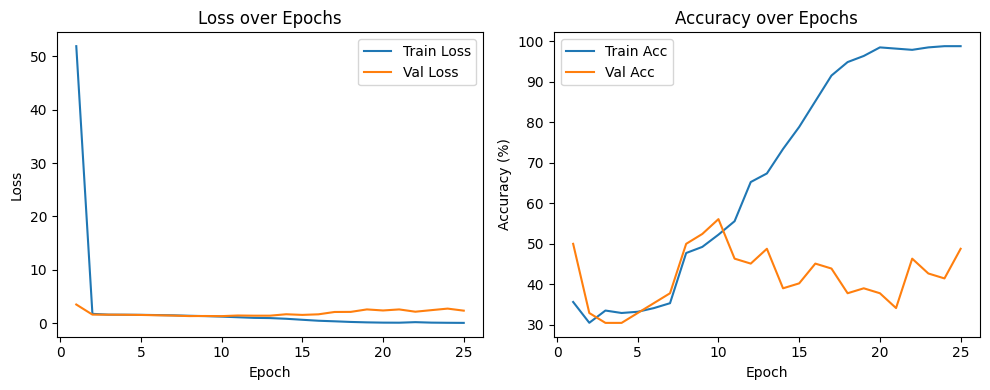

In [11]:
epochs_range = range(1, len(train_losses) + 1)

# Loss plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Acc')
plt.plot(epochs_range, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()